# Gömb illesztés RANSAC eljárással

A RANSAC eljárás alkalmazásának általában mindig a leginkább munkaigényes része a becsléshez szükséges modell megalkotása. Most is kezdjük ezzel a munkát.

## Modell meghatározása

### Egyértelmű meghatározás 4 pont alapján

Először 4 ismert helyzetű $P_i(x_i,y_i,z_i)$ pontra illesztünk gömböt algebrai módszerrel. Négy pont esetében $i=1,...,4$ a feladat egyértelműen megoldható lineáris egyenletrendszerhez vezet (lásd Paláncz, Molnár (2012) [Wolfram Library Archive](http://library.wolfram.com/infocenter/MathSource/8491/)).

Mindegyik pontra illeszkedik az $R$ sugarú gömb:
$$ \sqrt{(x_i-x_0)^2+(y_i-y_0)^2+(z_i-z_0)^2} -R = 0 $$

ezért mindegyik pontra
$$ \sqrt{(x_i-x_0)^2+(y_i-y_0)^2+(z_i-z_0)^2} +R = 2R = c $$

A két egyenletet összeszorozva
$$ (x_i-x_0)^2+(y_i-y_0)^2+(z_i-z_0)^2 -R^2 = 0 $$

Az $R$ helyett új $\alpha$ ismeretlent bevezetve az alábbi *lineáris* egyenletrendszert kell megoldani a $\mathbf{p}=[x_0, y_0, z_0, \alpha]$ paraméterekre
$$ x_i^2 + y_i^2 + z_i^2 -2x_0 x_i -2y_0 y_i - 2z_0 z_i + \alpha = 0$$
ahol
$$ \alpha = x_0^2 + y_0^2 + z_0^2 -R^2$$

A feladat megoldását az alábby Python függvény tartalmazza:


In [1]:
def sph4modell(X):
    """
    sph4modell(X) gömböt határoz meg négy, az, X mátrix soraiban megadott pontra
    Hivatkozás: Paláncz, Molnár (2012): Fitting sphere to quantized depth information
    Input:  X: 4x3-as mátrix, a négy pont [x,y,z] koordinátái (sorvektorokként tárolva)
    Output: 4 elemű vektorban  [x0, y0, z0, r], ahol:
              r: a gömb sugara
              x0, y0, z0: a gömb középpontjának koordinátái
    Megjegyzés:  Ha nincs megoldás (a 4 pont közel egy síkba esik, akkor a
                 függvény visszatérési értéke None
    """

    # átlagértékeket levonjuk
    Xm = np.mean(X,axis=0)
    Xs = X-Xm

    # M mátrix
    M=np.hstack((-2.0*Xs,np.ones((4,1))))
    # h vektor
    h=-np.sum(Xs**2,axis=1)  # sorok összegzése
    # kondíciószám ellenőrzése:
    if np.linalg.cond(M) > 1000:
        return None
    # determináns ellenőrzése:
    if np.abs(np.linalg.det(M)) < 1.0e-15:
        return None
    p=np.linalg.solve(M,h)
    # gömb sugara
    r=np.sqrt(np.sum(p[0:3]**2)-p[3])
    # középpont koordinátái
    c=p[0:3]+Xm
    return np.hstack((c,r))


Teszteljük a függvényt!

In [2]:
import numpy as np

X = np.array([[0.655416348349, 0.200995185452, 0.893622387647], 
              [0.281886543129, 0.525000382971, 0.314126774995], 
              [0.444615678299, 0.299474455628, 0.282689857776], 
              [0.883227485267, 0.270905975731, 0.704419015849]])

p = sph4modell(X)
print p

[ 0.54748534  0.49907036  0.62914037  0.41285427]


### Illesztés legkisebb négyzetek módszerével több mint 4 pont esetén

Több mint 4 pont esetén a legkisebb négyzetek módszerével készíthetünk illeszkedő gömböt. Ehhez az alábbi Python függvényeket írtuk meg.

In [3]:
def svdsolve(a,b):
    u,s,v = np.linalg.svd(a)
    c = np.dot(u.T,b)
    w = np.divide(c[:len(s)],s)
    x = np.dot(v.T,w)
    return x

def sph4fit(X):
    """
    sph4fit(X) gömböt határoz meg négy vagy több, az, X mátrix soraiban megadott pontra
    Hivatkozás: Paláncz, Molnár (2012): Fitting sphere to quantized depth information
    Input:  X: nx3-as mátrix, az n pont [x,y,z] koordinátái (sorvektorokként tárolva)
    Output: 4 elemű vektorban  [x0, y0, z0, r], ahol:
              r: a gömb sugara
              x0, y0, z0: a gömb középpontjának koordinátái
    Megjegyzés:  Ha nincs jó megoldás, akkor a függvény visszatérési értéke None
    """

    # átlagértékeket levonjuk
    Xm = np.mean(X,axis=0)
    Xs = X-Xm
    n = Xs.shape[0]

    # M mátrix
    M=np.hstack((-2.0*Xs,np.ones((n,1))))
    # h vektor
    h=-np.sum(Xs**2,axis=1)  # sorok összegzése
    # kondíciószám ellenőrzése:
    if np.linalg.cond(M) > 1000:
        return None
    p=svdsolve(M,h)
    # gömb sugara
    r=np.sqrt(np.sum(p[0:3]**2)-p[3])
    # középpont koordinátái
    c=p[0:3]+Xm
    return np.hstack((c,r))

Ezt a függvényt is teszteljük:

In [4]:
# 10 pont
Xp = np.array([[0.236419323876, 0.94539908057,  0.448603985892], 
               [0.132256383655, 0.0585420373716,0.189678073452], 
               [0.777527902317, 0.237423931798, 0.978964303253], 
               [0.0367820896797,0.191109494886, 0.64247854129 ],
               [0.233535838244, 0.0910807008584,0.899334281424], 
               [0.983635710836, 0.211019679874, 0.552776867983], 
               [0.494141778444, 0.579783629292, 0.811875091404], 
               [0.983877207446, 0.262955546077, 0.993804390297], 
               [0.901832244664, 0.240795911508, 0.635966928702], 
               [0.151086132434, 0.251504104295, 0.33397148847 ]])

p10 = sph4fit(Xp)
print p10

[ 0.50949211  0.39356424  0.54173242  0.5305028 ]


Azért, hogy lássuk az illeszkedést, kiszámítjuk a pontok eltéréseit (előjelesen vagy előjel nélkül) az illeszkedő gömb felszínéhez képest. Ezt a következő függvénnyel valósíthatjuk meg:

In [5]:
def sphdist(sph,X,pos=1):
    """
    sphdist(sph,X) az X pontok távolságát számítja ki a sph gömbtől
    sph: 4-elemű vektor: [x0, y0, z0, r]
         x0, y0, z0: a gömb középpontja
         r: a gömb sugara
         X: (n,3) mátrix, az n db. pont koordinátái
       pos: ha pos=0, előjeles távolságokat számít ki, egyébként nem
    """
    r = sph[3]
    c = sph[0:3]
    # középponttól vett távolság négyzete
    dc = np.sum((X-c)**2,axis=1)
    if pos==1:
        dist = np.abs(np.sqrt(dc)-r)
    else:
        dist = np.sqrt(dc)-r
    return dist

A 4 pontos illesztés eltérései az egyes pontokban:

In [6]:
print sphdist(p,X)

[  5.55111512e-17   5.55111512e-17   0.00000000e+00   0.00000000e+00]


Ugyanez 10 pont esetében:

In [7]:
print sphdist(p10,Xp)

[ 0.09220366  0.08471174  0.00558926  0.00648709  0.01312137  0.02231322
  0.20203613  0.13768049  0.09905282  0.09255243]


Ha több kivágó (outlier) pontunk van, akkor a legkisebb négyzetek szerinti illesztés nem ad megfelelő eredményt. Ezért helyette a RANSAC megoldást fogjuk alkalmazni (Fischler M A, Bolles R C, Random Sample Consensus: A paradigm for model fitting with applications to image analysis and automated cartography, Communications of the ACM, 24(6): 381-395, 1981, [PDF](http://www.cs.columbia.edu/~belhumeur/courses/compPhoto/ransac.pdf)).

Az előzőekben tehát megvizsgáltuk a gömbillesztés modelljének megalkotását, és az illesztés problémájának megoldását legkisebb négyzetek módszerével. A gyakorlatban azonban sokszor olyan adataink vannak, amelyek nagy százalékban tartalmaznak durva hibás, azaz kivágó (outlier) értékeket. Fischler és Bolles kiváló módszert adtak az ilyen adatokból történő paraméterbecslésre 1981-es cikkükben, amely jól alkalmazható a mi problémánkra is.

Ahogy azt már az [ellipszis illesztési feladatnál](https://nbviewer.jupyter.org/github/gyulat/Korszeru_matek/blob/master/RANSAC.ipynb) láttuk, a RANSAC módszer a következő lépésekből áll:

1. Állítsunk elő egy előre meghatározott $M$ számú modellt (hipotézist), mindegyiket a modell egyértelmű megalkotásásához szükséges minimális $n$ darab adat alapján (ez a modell paraméterek meghatározását jelenti)
2. Értékeljük ki mindegyik modellt (hipotézist):
   * számítsuk ki az összes adat illeszkedési eltéréseit a modellhez képest
   * egy adott hibaküszöbön belüli adatok alkotják a konform adathalmazt (ún. „konszenzus” halmazt) 
3. Azt a modellt (hipotézist) választjuk, amelynek konform (konszenzus) halmaza a legtöbb elemből áll (ez az eredeti RANSAC módszerben alkalmazott kritérium)

A RANSAC eljárás alkalmazásához tehát rendelkeznünk kell a következő algoritmusokkal (függvényekkel):
* modell létrehozása a minimálisan szükséges $n$ adat alapján
* illeszkedési eltérések számítása egy adott modellhez képest

A gömbillesztési probléma esetében már megírtuk ezeket a függvényeket, így csak be kell integrálnuk őket a [scikit-image](http://scikit-image.org/) eljáráskönyvtárban található [ransac](http://scikit-image.org/docs/stable/api/skimage.measure.html?highlight=ransac#skimage.measure.ransac) függvénybe.

A függvény leírásából kiderül, hogy a 
```python
sm.ransac(data, model_class, min_samples, residual_threshold) 
```
függvénynek négy kötelező paramétere van. 
1. Az adatok  `data(N, D)` méretű tömbje, ahol `N` az adatok száma, `D` az adatok dimenziója,
2. a modellt megvalósító Python osztály (class), aminek kötelező tagfüggvényei a `success = estimate(*data)` és a `residuals(*data)`,
3. a `min_samples` egész szám, ami az előzőekben említett $n$.
4. a `residual_threshold`, a leírás alapján az adatpontnak az a maximális távolsága, amíg még konform, a modellhez illeszkedő adatnak számít.

### A SphereModel Python osztály

A RANSAC eljáráshoz a mi esetünkben szükséges osztályt (`SphereModel`) egy egyszerű konstruktor és a két szükséges tagfüggvény alkotja. A függvény használja a korábbi `svdsolve` függvényt, így annak a kódja is szerepel. A `params` tagváltozó a meghatározott gömb paramétereit (középpont és sugár) tárolja.

In [8]:
class SphereModel:
    """sphere fitting model 
    """

    def __init__(self):
        self.params = np.zeros(4)

    def estimate(self, X):
        """
        estimate(X) gömböt határoz meg négy vagy több, az, X mátrix soraiban megadott pontra
        Hivatkozás: Paláncz, Molnár (2012): Fitting sphere to quantized depth information
        Input:  X: nx3-as mátrix, az n pont [x,y,z] koordinátái (sorvektorokként tárolva)
        Eredmény: paraméter 4 elemű vektorban  params: [x0, y0, z0, r], ahol:
                  r: a gömb sugara
                  x0, y0, z0: a gömb középpontjának koordinátái
        Megjegyzés:  Ha nincs jó megoldás, akkor a függvény visszatérési értéke False
        """

        # átlagértékeket levonjuk
        Xm = np.mean(X,axis=0)
        Xs = X-Xm
        n = Xs.shape[0]

        # M mátrix
        M=np.hstack((-2.0*Xs,np.ones((n,1))))
        # h vektor
        h=-np.sum(Xs**2,axis=1)  # sorok összegzése
        # kondíciószám ellenőrzése:
        if np.linalg.cond(M) > 1000:
            return False
        self.params=svdsolve(M,h)
        # gömb sugara
        r=np.sqrt(np.sum(self.params[0:3]**2)-self.params[3])
        self.params[3]=r
        # középpont koordinátái
        self.params[0:3] = self.params[0:3]+Xm
        return True
    
    def residuals(self, X, pos=1):
        """
        residuals(X) az X pontok távolságát számítja ki a sph gömbtől
        params: 4-elemű vektor: [x0, y0, z0, r]
             x0, y0, z0: a gömb középpontja
             r: a gömb sugara
             X: (n,3) mátrix, az n db. pont koordinátái
           pos: ha pos=0, előjeles távolságokat számít ki, egyébként nem
        """
        r = self.params[3]
        c = self.params[0:3]
        # középponttól vett távolság négyzete
        dc = np.sum((X-c)**2,axis=1)
        if pos==1:
            dist = np.abs(np.sqrt(dc)-r)
        else:
            dist = np.sqrt(dc)-r
        return dist
    
def svdsolve(a,b):
    u,s,v = np.linalg.svd(a)
    c = np.dot(u.T,b)
    w = np.divide(c[:len(s)],s)
    x = np.dot(v.T,w)
    return x

### Teszt adatok

Az alábbi teszt [adatokat](./dat/sphere.dat) használjuk fel (lézerszkenneres referencia gömb mérés, [Rehány Nikolett][rn]-től kapott adatok). A beolvasott pontfelhő így néz ki:
[rn]: http://www.epito.bme.hu/rehany-nikolett

/home/tg/.local/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


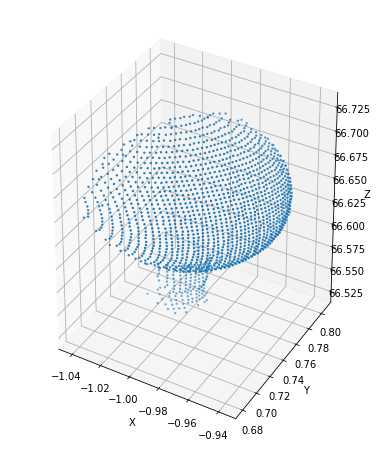

In [9]:
%matplotlib inline
import numpy as np
import skimage.measure as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## teszt adatok (1581 pont)
X1=np.loadtxt("./dat/sphere.dat")

## kirajzoljuk
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal', projection='3d')
ax.scatter(X1[:,0], X1[:,1], X1[:,2], s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


Az adatok beolvasása után elvégezzük a gömb RANSAC becslését. Az esetünkben a `min_samples = 4`. A `residual_threshold` értékét nem vehetjük se túl nagyra, se túl kicsire. Némi próbálkozás után a `0.07` értéket találhatjuk célszerűnek.

In [10]:
ransac_model, inliers = sm.ransac(X1, SphereModel, 4, 0.003)

np.set_printoptions(suppress=True)
print "paraméterek  : ", ransac_model.params
print "pontok száma : ", X1.shape[0]
print "kivágó pontok: ", X1.shape[0]-np.sum(inliers)

paraméterek  :  [ -1.00667579   0.75261064  66.65212204   0.06947287]
pontok száma :  1581
kivágó pontok:  158


Ha az előző számítást többször egymás után megismételjük, akkor azt tapasztalhatjuk, hogy minden esetben kissé változnak a becsült paraméterek és a kivágó pontok száma. Ez a RANSAC módszer véletlen jellegéből fakad - az eredmény függ az adott próbálkozástól.

Rajzoljuk fel a kapott konszenzus halmazt és a kivágó pontokat:

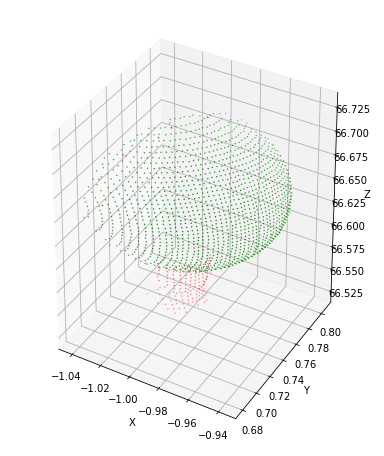

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal', projection='3d')
ax.scatter(X1[inliers,0], X1[inliers,1], X1[inliers,2], edgecolors='none', c='green',s=2)
outliers = np.invert(inliers)
ax.scatter(X1[outliers,0], X1[outliers,1], X1[outliers,2], edgecolors='none', c='red',s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Illeszkedési eltérések
Rajzoljuk ki az illeszkedési eltérések hisztogramját csak a konform pontokra.

átlag:    -0.00 %
szórás:    0.70 %
max:       4.98 %


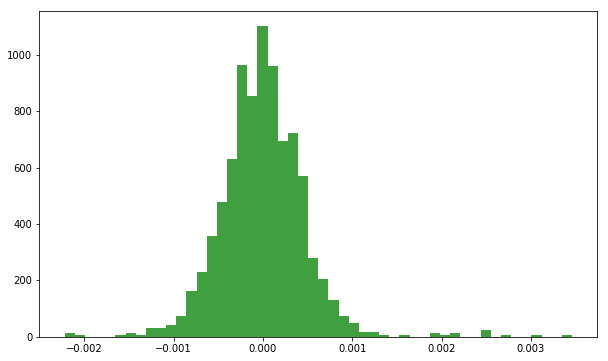

In [12]:
def sphdist(sph,X,pos=1):
    """
    sphdist(sph,X) az X pontok távolságát számítja ki a sph gömbtől
    sph: 4-elemű vektor: [x0, y0, z0, r]
         x0, y0, z0: a gömb középpontja
         r: a gömb sugara
         X: (n,3) mátrix, az n db. pont koordinátái
       pos: ha pos=0, előjeles távolságokat számít ki, egyébként nem
    """
    r = sph[3]
    c = sph[0:3]
    # középponttól vett távolság négyzete
    dc = np.sum((X-c)**2,axis=1)
    if pos==1:
        dist = np.abs(np.sqrt(dc)-r)
    else:
        dist = np.sqrt(dc)-r
    return dist

# előjeles távolságokat számítunk
v = sphdist(ransac_model.params,X1[inliers,:],0)

# sugárhoz viszonyított százalékos eltérések
print "átlag:  %7.2f" % (100*np.mean(v)/ransac_model.params[3]) + " %"
print "szórás: %7.2f" % (100*np.std(v)/ransac_model.params[3]) + " %"

# max. százalékos eltérés
print "max:    %7.2f" % (100*np.max(np.abs((v)))/ransac_model.params[3]) + " %"

# relatív eltérések hisztogramja
fig = plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(v, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()

### Kvantilis-kvantilis ábra (Q-Q plot)

A normalitás grafikus ellenőrzéséhez használjunk normális kvantilis-kvantilis ábrát.

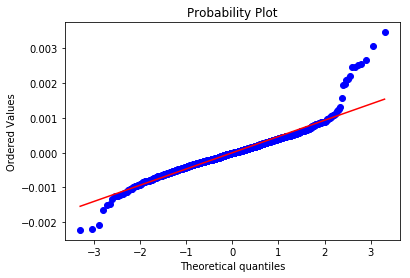

In [13]:
import scipy.stats as stats

stats.probplot(v, dist="norm", plot=plt)
plt.show()

A szárnyakon a Gauss-eloszlástól való eltérést tapasztalunk.

### A RANSAC további változatai

A RANSAC becslésnek sokféle változata alakult ki az évek során. Ezek többek között az M-becslő MSAC, a Maximum Likelihood MLESAC, illetve a KALMANSAC. A módszer olyan változata is létezik, amikor az adatokban a keresett modell több példánya is jelen van ([Toldo és Fusiello, 2008](https://pdfs.semanticscholar.org/0455/e5596d734e3dcf60c0179efb6404e62ceabb.pdf)). A BaySAC változatban pedig nem véletlenszerűen választják ki a modelleket, hanem mindig azt a modellt keresik, amely legnagyobb valószínűséggel lehet helyes azon előzetes információ (prior) alapján, hogy mely modellek bizonyultak már hibásnak. 